<a href="https://colab.research.google.com/github/DDD26/tum-adlr-ws20-02/blob/main/ADLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
## basic setup ##
!pip install stable-baselines3[extra]
!apt-get install ffmpeg freeglut3-dev xvfb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.7).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [90]:
## import ##
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy.ndimage as ndimage
from scipy.signal import convolve2d
import torch

In [162]:
### define our robot environment ###
class Environment():
    def __init__(self, pos, size, bound, voxel_size = np.array([0.1,0.1]), eps=1, order=1):
        """
        Args: 
            pos: np array with shape [N,2], with N being number of obstacles, indicating coordinate of obstacle'slower left corner
            size: np array with shape [N,2], with N being number of obstacles, indicating width and hight of obstacles
            bound: np array with shape [2,], upper boundary of the work space. Lower bound is implicitly (0,0)
        """
        self.pos = pos.astype(int)
        self.size = size.astype(int)
        self.bound = bound.astype(int)
        self.voxel_size = voxel_size
        self.ob_num = pos.shape[0]
        #self.max_ob = np.max(size, axis = 0)
        self.eps = eps
        self.order = order 
        
        self.obstacle = self.obstacle()
        self.dis = self.dis() 
        self.dis_der = self.dis_der()
        self.dis_fun = self.dis_fun1()
        self.dis_der_fun = self.dis_der_fun1()
        self.cost_fun = self.cost_fun1()
        self.cost_der_fun = self.cost_der_fun1()
                
    def obstacle(self):
        """
        geometric shape of the environment 
        Returns: 
            obstacle: a boolean numpy array same shape as attribute bound, True indicates obstacle, False indicates free 
        """
        pos = self.pos
        size = self.size 
        bound = self.bound
        obstacle = np.zeros(bound,dtype = bool)
        for i in range(pos.shape[0]):
            low_left = pos[i]
            up_right = low_left + size[i]
            obstacle[tuple(map(slice, low_left, up_right))] = True
        return obstacle 
    
    def dis(self):
        """
        create nearest distance field, negative indicates inside obstacle
        Returns: 
            dis: a float numpy array same shape as attribute bound
        """
        bound = self.bound
        voxel_size = self.voxel_size 
        
        im = self.obstacle
            
        pad = np.ones(self.bound+2, dtype=bool)
        pad[1:bound[0]+1,1:bound[1]+1] = im    
            
        dis = ndimage.distance_transform_edt(-pad.astype(int) + 1, sampling=voxel_size)
        dis1 = ndimage.distance_transform_edt(pad.astype(int), sampling=voxel_size)
        dis[pad] = - dis1[pad]  # Add interior information
            
        dis = dis[1:bound[0]+1,1:bound[1]+1]
        return dis
    
    def dis_der(self):
        """
        applying sobel filter to nearest distance field to get and x and y gradient field 
        Returns: 
            dis_der: a float numpy array with shape [2,bound[0],bound[1]], x gradient and y gradient 
        """
        dis_der = np.zeros((2,self.bound[0],self.bound[1]),dtype=np.float64)
        for d in range(2):  # Treat image boundary like obstacle
            dis_der[d, ...] = ndimage.sobel(self.dis, axis=d, mode='constant', cval=0)/self.voxel_size[d]
        return dis_der
    
    def dis_fun1(self):
        """
        interpolate the nearest distance to get distance function
        Returns: 
            dis_fun: a function whose input is float numpy array with shape [N,2], N is number of inquiry points
                                      output is float numpy array with shape [N,], respecting cost of each inquiry points
        """ 
        factor = 1/self.voxel_size
        im = self.dis
        def dis_fun(x):
            x = np.multiply(x,factor)-0.5
            out = ndimage.map_coordinates(im, coordinates=x.T, order=self.order, mode='nearest')
            return out          
        return dis_fun
    
    def dis_der_fun1(self):
        """
        interpolate the x and y gradient field to get distance gradient function
        Returns: 
            dis_der_fun: a function whose input is float numpy array with shape [N,2], N is number of inquiry points
                                      output is float numpy array with shape [N,2], respecting x and y gradient of each point
        """ 
        der = self.dis_der
        factor = 1/self.voxel_size
        def dis_der_fun(x):
            x = np.multiply(x,factor)-0.5
            gx = ndimage.map_coordinates(der[0,...], coordinates=x.T, order=self.order, mode='nearest')
            gy = ndimage.map_coordinates(der[1,...], coordinates=x.T, order=self.order, mode='nearest')
            return np.stack((gx,gy),axis=0).T
        return dis_der_fun
    
    def cost_fun1(self):
        """
        assign cost to nearest distance field
        Returns: 
            cost_fun: a function whose input is float numpy array with shape [N,2], N is number of inquiry points
                                       output is float numpy array with shape [N,], cost of each point
        """
        eps = self.eps
        def cost_fun(x):
            dis = self.dis_fun(x)
            cost = np.zeros(dis.shape,dtype=np.float64)
            cost[dis>eps] = 0
            cost[np.logical_and(dis>0,dis<=eps)] = np.square(dis[np.logical_and(dis>0,dis<=eps)]-eps)/(2*eps)
            cost[dis<=0] = eps/2 - dis[dis<=0]
            return cost
        return cost_fun

    def cost_der_fun1(self):
        """
        assign cost gradient
        Returns: 
            cost_der_fun: a function whose input is float numpy array with shape [N,2], N is number of inquiry points
                                           output is float numpy array with shape [N,2], x and y cost gradient of each point
        """
        eps = self.eps
        def cost_der_fun(x):
            dis = self.dis_fun(x)
            dis_der = self.dis_der_fun(x)
            der = cost = np.zeros((len(dis),2),dtype=np.float64)
            der[dis>eps] = 0
            der[np.logical_and(dis>0,dis<=eps)] = np.multiply((dis[np.logical_and(dis>0,dis<=eps)]-eps),dis_der[np.logical_and(dis>0,dis<=eps)].T).T/eps
            der[dis<=0] = - dis_der[dis<0]
            return der 
        return cost_der_fun

      

        
class Objective():
    def __init__(self,start, end, opt_num, sp_num,co_num, environment,w):
        """
        Args: 
            start: np array with shape [2,], start point of the robot
            end: np: array with shape [2,], end point of the robot
            opt_num: number of optimization points 
            sp_num: number of sampling points on line segements between two optimization points for calculating objective
            environment: environment the objective function based on
            w: weight term for length objective 
            ob_fun: objective function 
            ob_der_fun: derivative of objective function
        """
        self.start = start 
        self.end = end
        self.opt_num = opt_num 
        self.sp_num = sp_num
        self.environment = environment
        self.w = w  #length weight 
        
        self.ob_fun = self.ob_fun1()
        self.ob_der_fun = self.ob_der_fun1()
        self.co_num = co_num
        
    def ob_fun1(self):
        """
        objective function
        Returns: 
            ob_fun: a function whose input is float numpy array with shape [opt_num, 2]
                                              output is float numpy scalar the objective value
        """
        env = self.environment
        w = self.w
        start = self.start
        end = self.end
        def ob_fun(x):
            x1 = self.all_points(x,self.sp_num)
            x1 = np.delete(x1,0,0)
            x1 = np.delete(x1,x1.shape[0]-1,0)
            return np.mean(env.cost_fun(x1)) + w*np.sum(np.diff(np.insert(x,(0,x.shape[0]),(start,end),axis=0),axis=0)**2)
        return ob_fun
    
    def ob_der_fun1(self):
        """
        derivative of objective function
        Returns: 
            ob_der_fun: a function whose input is a float numpy array with shape [opt_num, 2]
                                         output is a float numpy array with shape [opt_num,2], the derivative 
        """
        env = self.environment
        w = self.w
        opt_num = self.opt_num
        sp_num = self.sp_num
        def ob_der_fun(x):
            ### gradient of obstacle cost ###
            x1 = self.all_points(x,self.sp_num)
            x1 = np.delete(x1,0,0)
            x1 = np.delete(x1,x1.shape[0]-1,0)
            x1 = self.environment.cost_der_fun(x1)
            x1 = torch.Tensor(x1).reshape(1,1,x1.shape[0],x1.shape[1])
            kernel1 = np.append(np.arange(1,sp_num+2,1),np.arange(sp_num,0,-1))/(sp_num+1)
            kernel1 = torch.Tensor(kernel1).reshape(1,1,kernel1.shape[0],1)
            re1 = torch.nn.functional.conv2d(x1,kernel1,stride=(sp_num+1,1))
            re1 = re1/(opt_num+(opt_num+1)*sp_num)
            re1 = torch.squeeze(torch.squeeze(re1,0),0).numpy()
            ### gradient of length cost ###
            x2 = np.insert(x,(0,x.shape[0]),(start,end),axis=0)
            x2 = torch.Tensor(x2).reshape(1,1,x2.shape[0],x2.shape[1])
            kernel2 = torch.Tensor([-1,2,-1]).reshape(1,1,3,1)
            re2 = 2*w*torch.nn.functional.conv2d(x2,kernel2,stride=1)
            re2 = torch.squeeze(torch.squeeze(re2,0),0).numpy()
            return re1+re2
        return ob_der_fun
    
    def all_points(self,x,num):
        """
        combine all start, end, optimization and subsampling points
        Args:
            x: float numpy array with shape [opt_num,2], optimization points
        Returns: 
            x1: float numpy array with shape [opt_num+2+sp_num*(opt_num+1), 2]
        """
        start = self.start 
        end = self.end 
        x1 = np.insert(x,(0,x.shape[0]),(start,end),axis=0)
        for i in range(x1.shape[0]-1):
            x2 = np.linspace(x1[i+(num)*i],x1[i+1+(num)*i],num+1,endpoint=False)
            x2 = np.delete(x2,0,0)
            x1 = np.insert(x1,i+1+(num)*i,x2,axis=0)
        return x1
    
    def initial(self):
        """
        initialize the trajectory by connecting start, end point and uniform sampling
        Returns: 
            x0: float numpy array with shape [opt_num, 2], initial optimization points
        """
        x0 = np.linspace(self.start,self.end,self.opt_num+1,endpoint=False)
        x0 = np.delete(x0,0,0)
        return x0

    def collision(self,x):
        low = self.environment.pos
        high = self.environment.pos + self.environment.size
        x1 = self.all_points(x,self.co_num)
        factor = 1/self.environment.voxel_size
        x1 = np.multiply(x1,factor)-0.5
        out = np.empty((x1.shape[0],),dtype=bool)
        print(out.shape)
        for i in range(x1.shape[0]):
            k = np.concatenate((x1[i]>low,x1[i]<high),axis=1)
            k = np.all(k,axis=1)
            out[i] = np.any(k)
            out1 = np.any(out)
            out2 = np.all([x1>0,x1<self.environment.bound])
        return not out1 and out2

In [195]:
## setup reinforcement learning environment ##
import numpy as np
import gym
from gym import spaces
class MPEnv(gym.Env):
    def __init__(self,objective):
        super(MPEnv, self).__init__()
        self.obj = objective 
        self.environment = self.obj.environment
        self.at_space_dim = self.obj.opt_num*2
        self.action_space = spaces.Box(low = -100, high = 100, shape=(self.at_space_dim,),dtype=np.float32)
        self.history_num = 1
        self.warp_dim = 2*self.obj.opt_num
        self.ob_space_dim = self.history_num*self.warp_dim       # history*(optimization points and derivative + objective value)  + start and end point  
        self.observation_space = spaces.Box(low=-100, high = 100, shape=(self.ob_space_dim,), dtype=np.float32)
        self.pos = self.obj.initial()
        self.observation = None

    def reset(self):
        x0 = self.obj.initial()
        self.pos = x0
        start = self.obj.start
        end = self.obj.end
        initial_der = self.obj.ob_der_fun(x0).flatten()
        initial_ob_val = np.array([self.obj.ob_fun(x0)])
        history = np.zeros((self.history_num-1)*(1+4*self.obj.opt_num),dtype=np.float32)
        self.observation = np.concatenate((history,initial_der),axis=0).astype(np.float32)
        return self.observation
    
    def step(self, action):
        self.pos = self.pos + action.reshape(self.obj.opt_num,2)
        self.pos = np.clip(self.pos,0,self.environment.bound*self.environment.voxel_size)

        new_observation = obj.ob_der_fun(self.pos).flatten()
        self.observation = np.delete(self.observation,range(0, self.warp_dim)) 
        self.observation = np.concatenate((self.observation,new_observation),axis=0).astype(np.float32) 
        done = bool(self.obj.collision(self.pos))
        reward = -self.obj.ob_fun(self.pos)
        info = {}
        return self.observation, reward, done, info

    def close(self):
        pass

In [196]:
from stable_baselines3.common.env_checker import check_env
pos = np.array([[10,10],[40,50],[15,35]])
size = np.array([[20,20],[10,30],[20,30]])
bound = np.array([64,64])
start = np.array([0.1,0.1])
end = np.array([6.3,6.3])
opt_num = 10
sp_num = 5
co_num = 20
w = 0.5
environment = Environment(pos,size,bound)
obj = Objective(start, end, opt_num, sp_num, co_num, environment, w)
ob_fun = obj.ob_fun
ob_der_fun = obj.ob_der_fun


#iter_num = 200
#lr = 0.2
#x0 = obj.initial()
#print(lr*ob_der_fun(x0))
#for i in range(iter_num):
#    x0 = x0 - lr*ob_der_fun(x0)
#b = environment.dis
#plt.imshow(b)
#print(obj.collision(x0))
#x0 = x0*10-0.5
#print(x0)
#plt.plot(x0.T[1],x0.T[0])

# If the environment don't follow the interface, an error will be thrown
#ob = env_ri.reset()
#print(ob.shape)
#print(env_ri.observation)
#print(env_ri.ob_space_dim)

In [209]:
from stable_baselines3 import PPO, A2C # DQN coming soon
from stable_baselines3.common.cmd_util import make_vec_env

from stable_baselines3 import PPO,SAC
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

env = MPEnv(obj)
#env = make_vec_env(lambda: env, n_envs=1)
check_env(env, warn=True)


model = SAC('MlpPolicy', env, gamma=1, verbose=1).learn(1000)


/usr/local/lib/python3.6/dist-packages/stable_baselines3/common/env_checker.py:232: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
Using cuda device
Wrapping the env in a DummyVecEnv.
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(2

(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
(232,)
[[-0.5 -0.5]
 [-0.5 63.5]
 [-0.5 63.5]
 [63.5 63.5]
 [63.5 63.5]
 [63.5 63.5]
 [63.5 63.5]
 [63.5 63.5]
 [63.5 63.5]
 [63.5 63.5]]


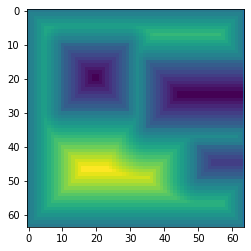

In [217]:
obs = env.reset()
n_steps = 20
for step in range(n_steps):
  action, _ = model.predict(obs, deterministic=True)
  obs, reward, done, info = env.step(action)
  if done:
    print("Goal reached!", "reward=", reward,"step=",step)
    break
x = env.pos
plt.imshow(environment.dis)
x = x*10-0.5
print(x)
plt.plot(x.T[1],x.T[0])